In [1]:
import os
import glob

import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import utils
from model import BadModel, BadModel2
from dataset import SwingDataset, augment

In [2]:
torch.__version__

'1.7.0'

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
path = "data/"

In [6]:
shot_types = ["Pull-hook", "Hook", "Pull", "Fade", "Straight", "Draw", "Push", "Slice" , "Push-slice"]

In [7]:
X_data, y_data = utils.load_data(path)

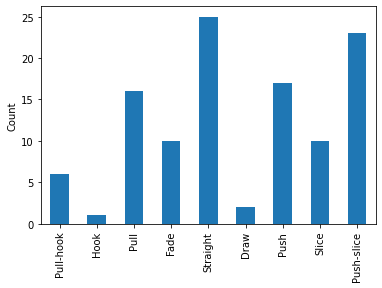

In [8]:
utils.plot_counts(y_data, xticks_label = shot_types)

In [9]:
n = X_data.shape[0]

# GENERATE DATA SPLITS
train = 0.75
val = 0.20
test = 0.05

X_train = X_data[:int(n*train),:,:] 
y_train = y_data[:int(n*train),:]

X_val = X_data[int(n*train):int(n*(val+train)),:,:]
y_val = y_data[int(n*train):int(n*(val+train)),:]

X_test = X_data[-int(n*test):,:,:]
y_test = y_data[-int(n*test):,:]

# /GENERATE DATA SPLITS

In [10]:
X_train.shape, X_val.shape, X_test.shape

((82, 6, 500), (22, 6, 500), (5, 6, 500))

In [11]:
train_set = SwingDataset(X_train, y_train, augment=True, oversample = True)
val_set = SwingDataset(X_val, y_val, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)
test_set = SwingDataset(X_test, y_test, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)

In [12]:
np.save("norm_data/X_mean.npy", train_set.mean)
np.save("norm_data/X_std.npy", train_set.std)
np.save("norm_data/y_mean.npy", train_set.y_dist_mean)
np.save("norm_data/y_std.npy", train_set.y_dist_std)

In [13]:
train_set.mean == np.load("norm_data/X_mean.npy")

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

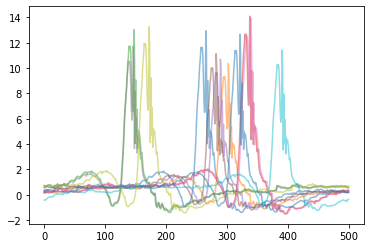

In [14]:
# test the data augmentation
plt.plot(train_set.X_data[0][0],alpha=0.5)
for _ in range(10):
    plt.plot(augment(train_set.X_data[0][0]), alpha=0.5)
plt.show()

In [15]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, drop_last=False, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, drop_last=False, shuffle=True)

In [32]:
bestmodel_file = os.path.join("weights", "best_model.pth")

model = BadModel2().to(device)
# model = MSResNet(input_channel=6, num_classes=10)

swing_type_loss = nn.CrossEntropyLoss()
# swing_type_loss = nn.BCEWithLogitsLoss()
#swing_type_loss = nn.BCELoss()
distance_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

losses = []
va_losses = []
num_epochs = 10
iter_idx = -1
best_va_loss = 9999 
val_interval = 50
report_interval = 10

In [41]:
loss_history = []
epochs = 100
for e in range(epochs):
    prefix = "Epoch {:3d}: ".format(e)
#     for data in tqdm(train_loader, desc=prefix):
    for data in train_loader:
        print(e, end="\r", flush=True)
        iter_idx += 1
        X_train, y = data
        
        X_train = X_train.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_train.float())
        swing_loss = swing_type_loss(outputs[:, :-1], torch.max(y[:, :-1], 1)[1])
        # swing_loss = swing_type_loss(outputs[:, :-1], y[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y[:, -1:])
        loss = 9 * swing_loss + dist_loss
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if iter_idx % val_interval == 0:
            va_loss = []
            model = model.eval()
            for data in val_loader:
                X_va, y_va = data
                X_va = X_va.to(device)
                y_va = y_va.to(device)
                with torch.no_grad():
                    outputs_va = model(X_va.float())               
                    swing_loss = swing_type_loss(outputs_va[:, :-1], torch.max(y_va[:, :-1], 1)[1])
                    # swing_loss = swing_type_loss(outputs_va[:, :-1], y_va[:, :-1])
                    dist_loss =  distance_loss(outputs_va[:, -1:], y_va[:, -1:])
                    loss = swing_loss + dist_loss
                    va_loss += [loss.cpu().numpy()]
                    
            model = model.train()
            va_loss = np.mean(va_loss)
            va_losses.append(va_loss)
            
            if va_loss < best_va_loss:
                best_va_loss = va_loss
                torch.save({
                    "iter_idx": iter_idx,
                    "best_va_loss": best_va_loss,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                }, bestmodel_file)

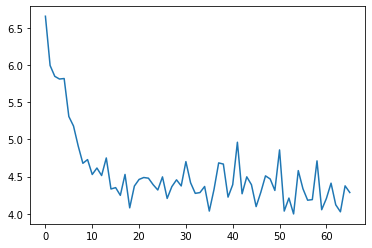

In [42]:
plt.plot(va_losses)

In [43]:
def print_preds(predictions, truth, mean, std):
    for pred, true in zip(predictions, truth):
        pred_distance = pred[-1] * std + mean
        pred_argmax = torch.argmax(pred[:-1])
        pred_shot_type = shot_types[pred_argmax]
        print(f"Pred: {pred_shot_type} {round(pred_distance.item())}yds")
        
        true_distance = true[-1] * std + mean
        true_argmax = torch.argmax(true[:-1])
        true_shot_type = shot_types[true_argmax]
        
        print(f"True: {true_shot_type} {round(true_distance.item())}yds")
        print()

In [44]:
print_preds(outputs, y, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Push-slice 125yds
True: Push-slice 90yds

Pred: Push-slice 118yds
True: Push 110yds



In [45]:
print_preds(outputs_va, y_va, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Pull 115yds
True: Pull-hook 140yds

Pred: Pull 49yds
True: Push-slice 70yds



# Test

In [46]:
# normalization moved to the dataloader
# X_test_norm = norm(X_test, train_mean, train_std)
# y_test_norm = y_test.copy()
# y_test_norm[:, -1] -= y_distance_mean
# y_test_norm[:, -1] /= y_distance_std

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, drop_last=False)

In [47]:
swing_losses, dist_losses, total_losses, = [], [], []
model = model.eval()
idx = 0

test_out = []
true_out = []
test_shot_types = []
true_shot_types = []

with torch.no_grad():
    for data in test_loader:
        idx += 1
        x_test, y_test = data
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        outputs = model(x_test.float())
        
        swing_loss = swing_type_loss(outputs[:, :-1], torch.max(y_test[:, :-1], 1)[1])
        # swing_loss = swing_type_loss(outputs[:, :-1], y_test[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y_test[:, -1:])
        total_loss = swing_loss + dist_loss
        
        swing_losses += [swing_loss.cpu().numpy()]
        dist_losses += [dist_loss.cpu().numpy()]
        total_losses += [total_loss.cpu().numpy()]
        
        print("Test example %d: swing_loss = %f, dist_loss = %f" % (idx, swing_losses[idx-1], dist_losses[idx-1]))
  
        test_out.append(outputs[0])
        true_out.append(y_test[0])
        test_shot_types.append(np.argmax(outputs[:, :-1]).item())
        true_shot_types.append(np.argmax(y_test[:, :-1]).item())
#         test_shot_dist.append(outputs[:,0].item())
#         true_shot_dist.append(y_test[:,0].item())
    
    avg_swing_loss = np.mean(swing_losses)
    avg_dist_loss = np.mean(dist_losses)
    avg_total_loss = np.mean(total_losses)
    print()
    print("Out of %d test examples: avg_swing_loss = %f, avg_dist_loss = %f, avg_total_loss = %f" % (idx, avg_swing_loss, avg_dist_loss, avg_total_loss))

Test example 1: swing_loss = 1.091189, dist_loss = 0.431636
Test example 2: swing_loss = 1.884332, dist_loss = 0.227471
Test example 3: swing_loss = 1.078187, dist_loss = 0.090178
Test example 4: swing_loss = 0.887734, dist_loss = 0.844384
Test example 5: swing_loss = 0.123442, dist_loss = 0.110874

Out of 5 test examples: avg_swing_loss = 1.012977, avg_dist_loss = 0.340908, avg_total_loss = 1.353885


In [48]:
print_preds(test_out, true_out, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Straight 112yds
True: Push-slice 90yds

Pred: Straight 124yds
True: Pull 140yds

Pred: Pull 110yds
True: Straight 120yds

Pred: Push-slice 40yds
True: Push-slice 70yds

Pred: Push-slice 81yds
True: Push-slice 70yds



In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
cm = confusion_matrix(true_shot_types, test_shot_types)

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

# for debugging...

In [ ]:
import torch.nn.functional as F

class BadModel2(nn.Module):

    def __init__(self):
        super(BadModel2, self).__init__()
        # kernel
        self.conv1 = nn.Conv2d(1, 10, (3, 20), stride=(3, 5))
        self.conv2 = nn.Conv2d(10, 16, (2, 15), stride=(1, 3))

        self.fc1_cls = nn.Linear(16 * 6, 120)  
        self.fc2_cls = nn.Linear(120, 84)
        self.fc3_cls = nn.Linear(84, 9)
        # self.softmax = nn.Softmax(dim=1)
        
        self.fc1_dist = nn.Linear(16 * 6, 50)
        self.fc2_dist = nn.Linear(50, 1)
        
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        
        x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (1,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (1,2))
                        
        x = x.view(-1, self.num_flat_features(x))
        
        x_cls = F.relu(self.fc1_cls(x))
        x_cls = self.dropout(x_cls)
        x_cls = F.relu(self.fc2_cls(x_cls))
        x_cls = self.dropout(x_cls)
        x_cls = self.fc3_cls(x_cls)
        # x_cls = self.softmax(x_cls)

        x_dist = F.relu(self.fc1_dist(x))
        x_cls = self.dropout(x_dist)
        x_dist = self.fc2_dist(x_dist)

        x = torch.cat([x_cls, x_dist], axis=1)
        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
inputs = torch.rand(4,6,500)

In [ ]:
inputs = torch.rand(4,6,500)
m = BadModel2()

In [ ]:
inputs = torch.rand(4,6,500)
m = BadModel2()
m(inputs)

In [ ]:
l = nn.MSELoss()
l()